
# Transformers para Visión (ViT)

La arquitectura del tranformer se propuso inicialmente para el aprendizaje de secuencia a secuencia, como la traducción automática. Con gran eficacia, los tranformers se convirtieron posteriormente en el modelo de elección en diversas tareas de procesamiento del lenguaje natural.
Sin embargo, en el campo de la visión artificial la arquitectura dominante
se había basado en las CNN. *¿Podemos adaptar tranformers para modelar datos de imagen*? Esta pregunta ha despertado un gran interés en la comunidad de visión artificial. Un [paper del 2020](https://arxiv.org/pdf/1911.03584.pdf) demostró teóricamente que la autoatención puede aprender a comportarse de manera similar a la convolución. Empíricamente, se tomaron parches de $2 \times 2$ de las imágenes como entrada, pero el pequeño tamaño del parche hace que el modelo solo sea aplicable a datos de imágenes con resoluciones bajas.

Sin restricciones específicas sobre el tamaño del parche, los *tranformers de visión* (ViT) extraen parches de las imágenes y los introducen en un encoder de tranformer para obtener una representación global, que finalmente se transformará para la clasificación. En particular, los tranformers muestran una mejor escalabilidad que las CNN: cuando se entrenan modelos más grandes en conjuntos de datos más grandes, los tranformers de visión superan a los ResNet por un margen significativo. Similar al panorama del diseño de arquitectura de red en el procesamiento del lenguaje natural, los tranformers también cambiaron las reglas del juego en la visión por computadora.




## CNN vs ViT: Sesgo Inductivo

El sesgo inductivo es un término utilizado en el aprendizaje automático para describir el conjunto de suposiciones que utiliza un algoritmo de aprendizaje para hacer predicciones. En términos más simples, el sesgo inductivo es como un atajo que ayuda a un modelo de aprendizaje automático a hacer conjeturas basadas en la información que ha visto hasta ahora.

Aquí hay un par de sesgos inductivos que observamos en las CNN:

* **Equivarianza traslacional**: un objeto puede aparecer en cualquier parte de la imagen y las CNN pueden detectar sus características.
* **Localidad**: los píxeles de una imagen interactúan principalmente con los píxeles circundantes para generar features.

Estos sesgos inductivos no existen en los ViT porque originalmente fueron pensados para trabajar con secuencias de palabras. Entonces, ¿cómo se desempeñan tan bien? Es porque su diseño basado en los mecanismos de atención son altamente escalables debido a su alto grado de paralelización. Por tanto, superan la necesidad de estos sesgos inductivos si se los entrena con cantidades supermasivas de imágenes.

## Modelo Original para NLP

### Flujo de Tensores



Ahora que hemos visto los componentes principales del modelo, comencemos a ver los diversos tensores y cómo fluyen entre estos componentes para convertir la entrada de un modelo entrenado en una salida.

Como es el caso en las aplicaciones NLP en general, comenzamos convirtiendo cada palabra de entrada en un vector utilizando un algoritmo de embedding.

![Imgur](https://i.imgur.com/5pF2VfG.png)

La transformación a embeddings solo ocurre en el encoder de más abajo. La abstracción que es común a todos los encoders es que reciben una lista de vectores, cada uno de tamaño 512: en el encoder inferior, serían los embeddings de las palabras, pero en los demás, sería la salida del encoder que está directamente debajo. El tamaño de esta lista es un hiperparámetro que podemos configurar; básicamente, sería la longitud de la oración más larga en nuestro conjunto de datos de entrenamiento.

Después de generar los embeddings de las palabras en nuestra secuencia de entrada, cada una de ellas fluye a través de cada una de las dos capas del encoder.

![Imgur](https://i.imgur.com/EPxkIRI.png)

Aquí comenzamos a ver una propiedad clave del Transformer, que es que la palabra en cada posición fluye a través de su propio camino en el encoder. Existen dependencias entre estas rutas en la capa de autoatención. Sin embargo, la capa feed-forward no tiene esas dependencias y, por lo tanto, las diversas rutas se pueden ejecutar en paralelo mientras fluye a través de esta capa.

![Imgur](https://i.imgur.com/UzTM32F.png)




### Auto-Atención

En la clase anterior, habíamos visto cómo mejoraba la performance de los modelos de secuencia a secuencia cuando el decoder prestaba atención a la frase entera procesada por el encoder antes de predecir cuál sería el siguiente token. Recordemos un poco ese proceso.

1. El decoder miraba el conjunto de estados ocultos que recibió del encoder (cada estado oculto está más asociado con una determinada palabra en la oración de entrada)
2. Se asignaba una puntuación a cada estado oculto (calculada por alguna función de atención como aditiva, producto escalar o producto escalar generalizado) y luego se les pasaba esos valores a un softmax
3. Se multiplicaba cada estado oculto por su puntaje "softmaxeado", amplificando así los estados ocultos con puntajes altos y diluyendo los estados ocultos con puntajes bajos
4. Se sumaba todo y obteníamos el vector de contexto

![Imgur](https://i.imgur.com/0CnIjmA.png)





En este proceso, a la hora de calcular esos puntajes tomábamos el estado oculto actual del decoder como query, y los estados ocultos de cada tiempo del encoder eran tanto las keys como los values.

![Imgur](https://i.imgur.com/O9ocqXJ.png)

Ahora, al hablar de auto-atención, las queries, las keys y los values provienen del mismo lugar: **los tokens de entrada**. A medida que el modelo procesa cada palabra (cada posición en la secuencia de entrada), la auto-atención le permite observar otras posiciones en la secuencia de entrada en busca de pistas que puedan ayudar a codificar mejor esta palabra.

Primero veamos cómo calcular la autoatención usando vectores, luego procedamos a ver cómo se implementa realmente, usando matrices.

El primer paso para calcular la autoatención es crear tres vectores a partir de cada uno de los vectores de entrada del encoder (en este caso, el embedding de cada palabra). Entonces, para cada palabra, creamos un vector query, un vector key y un vector value. Estos vectores se crean multiplicando el embedding por tres matrices que entrenamos durante el proceso de entrenamiento.

Tenga en cuenta que estos nuevos vectores son más pequeños en dimensión que el vector embedding. Su dimensionalidad es 64, mientras que los embeddings y los vectores de entrada/salida de los encoders tienen una dimensionalidad de 512. No es obligatorio que sean más pequeños, esta es una elección de arquitectura que explicaremos más adelante.

![Imgur](https://i.imgur.com/tXhnp1U.png)

El segundo paso para calcular la autoatención es calcular una puntuación. Digamos que estamos calculando la autoatención de la primera palabra en este ejemplo, "Thinking". Necesitamos puntuar cada palabra de la oración de entrada contra esta palabra. La puntuación determina cuánta atención prestar en otras partes de la oración de entrada a medida que codificamos una palabra en una posición determinada.

La puntuación se calcula tomando el producto escalar del vector query con el vector key de la palabra respectiva que estamos puntuando. Entonces, si estamos procesando la autoatención de la palabra en la posición n. ° 1, el primer puntaje sería el producto escalar de q1 y k1. La segunda puntuación sería el producto escalar de q1 y k2.

![Imgur](https://i.imgur.com/LK5HwRT.png)

Los pasos tercero y cuarto consisten en dividir las puntuaciones por 8 (la raíz cuadrada de la dimensión de los vectores key utilizados en el paper: 64). Esto lleva a tener gradientes más estables. Podría haber otros valores posibles aquí, pero este es el predeterminado), luego pase el resultado a través de una operación softmax. Softmax normaliza las puntuaciones para que se comporten como una distribución de probabilidad (todas sean positivas y sumen 1).

![Imgur](https://i.imgur.com/EohRASF.png)

Esta puntuación softmax determina cuánto se enfocará cada palabra en esta posición. Claramente, la palabra en esta posición tendrá la puntuación de softmax más alta, pero a veces es útil prestar atención a otra palabra que sea relevante para la palabra actual.

El quinto paso es multiplicar cada vector de valor por la puntuación softmax (en preparación para sumarlos). La intuición aquí es mantener intactos los valores de las palabras en las que queremos centrarnos y diluir las palabras irrelevantes (multiplicándolas por números pequeños como 0,001, por ejemplo).

El sexto paso es sumar los vectores de valores ponderados. Esto produce la salida de la capa de autoatención en esta posición (para la primera palabra).

![Imgur](https://i.imgur.com/7ghvKCr.png)

### Múltiples Cabezales

El paper refina aún más la capa de autoatención al agregar un mecanismo llamado atención de "múltiples cabezales". Esto mejora el rendimiento de la capa de atención de dos maneras:

* Expande la capacidad del modelo para enfocarse en diferentes posiciones. Sí, en el ejemplo anterior, z1 contiene un poco de las otras posiciones, pero podría estar dominada por la propia palabra. Si estamos traduciendo una oración como “El animal no cruzó la calle porque estaba demasiado cansado”, sería útil saber si el "estaba" se refiere al animal o a la calle .

* Da a la capa de atención múltiples “subespacios de representación”. Como veremos a continuación, con la atención de varios cabezales no solo tenemos uno, sino varios conjuntos de matrices de pesos de Query/Key/Value (el Transformer utiliza ocho cabezales de atención, por lo que terminamos con ocho conjuntos para cada encoder/decoder) . Cada uno de estos conjuntos se inicializa aleatoriamente. Luego, después del entrenamiento, cada conjunto se usa para proyectar los embeddings de entrada (o los vectores de salida de los encoders/decoders inferiores) en un subespacio de representación diferente.

![Imgur](https://i.imgur.com/AspKg0z.png)

Si hacemos el mismo cálculo de autoatención que describimos anteriormente, solo ocho veces diferentes con diferentes matrices de peso, terminamos con ocho matrices Z diferentes.

![Imgur](https://i.imgur.com/i2dtHH6.png)

Esto nos deja con un pequeño desafío. La capa feed-forward no espera ocho matrices, espera una sola matriz (un vector para cada palabra). Así que necesitamos una forma de condensar estos ocho en una sola matriz.

¿Como hacemos eso? Concatenamos las matrices y luego las multiplicamos por una matriz de pesos adicional $W^O$.

![Imgur](https://i.imgur.com/rAgPw9N.png)



Y eso es todo el proceso de Auto-Atención con Múltiples Cabezales. Pongamos todo en un mismo gráfico para ver el pipeline completo.

![Imgur](https://i.imgur.com/2JljHSG.png)

### Codificación Posicional

Una cosa que falta en el modelo tal como lo hemos descrito hasta ahora es una forma de codificar el orden de las palabras en la secuencia de entrada. Debido a que ya no tenemos RNNs que procesen el problema de manera secuencial, esto puede llegar a ser un problema.

Para abordar esto, el Transformer agrega un vector a cada embedding de entrada. Estos vectores siguen un patrón específico que aprende el modelo, lo que le ayuda a determinar la posición de cada palabra o la distancia entre diferentes palabras en la secuencia. La intuición aquí es que agregar estos valores a los embeddings proporciona distancias significativas entre los vectores de embeddings una vez que se proyectan en vectores Q/K/V y durante la atención de producto escalar.

![Imgur](https://i.imgur.com/thGgU8N.png)

Hay muchas opciones de codificaciones posicionales, tanto aprendidas como fijas.

En este trabajo utilizaron funciones seno y coseno de diferentes frecuencias:
$$PE(pos,2i)=sin(pos/10000^{2i/embedsize})$$

$$PE(pos,2i+1)=cos(pos/10000^{2i/embedsize})$$

donde pos es la posición e i es la dimensión. Es decir, cada dimensión de la codificación posicional corresponde a una sinusoide. Las longitudes de onda forman una progresión geométrica de 2π a 10000⋅2π. Los autores eligieron esta función porque intuían que permitiría que el modelo aprendiera fácilmente a atender por posiciones relativas, ya que para cualquier desplazamiento k fijo, $PE(pos+k)$ puede representarse como una función lineal de $PE(pos)$

La siguiente imagen muestra cómo se ve este patron.
![Imgur](https://i.imgur.com/PGQFIKU.png)



### Conexiones Residuales




Un detalle de la arquitectura del encoder que debemos mencionar antes de continuar es que cada subcapa (autoatención, feed-forward) en cada encoder tiene una conexión residual a su alrededor, y va seguida de un paso de normalización de capa.

![Imgur](https://i.imgur.com/3KZCxga.png)

La normalización es buena para los modelos. Reduce el tiempo de entrenamiento, evita que el modelo se sesgue hacia características de mayor valor y no permite que los pesos exploten por todos lados restringiéndolos a un cierto rango. Por todo esto, no es deseable entrenar un modelo con descenso de gradiente con características no normalizadas.

En la normalización de capa, tomamos la media y la desviación estandar de todas las características de una sola oración y aplicamos la siguiente fórmula:

$$x_{norm} = \frac{x - mean(x)}{std(x)}$$

![Imgur](https://i.imgur.com/sbsytjy.png)

Esto también se aplica a las subcapas del decoder. Si tuviéramos que pensar en un transformer con 2 encoders y 2 decoders apilados, se vería así:

![Imgur](https://i.imgur.com/EI0DeiK.png)


### Etapa de Decodificación



Ahora que hemos cubierto la mayoría de los conceptos en el lado del encoder, básicamente también sabemos cómo funcionan los componentes de los decoders. Pero echemos un vistazo a cómo funcionan juntos.

El encoder comienza procesando la secuencia de entrada. La salida del encoder superior se transforma luego en un conjunto de vectores de atención K y V. Estos deben ser utilizados por cada decoder en su capa de "atención encoder-decoder" que ayuda al decoder a enfocarse en los lugares apropiados en la secuencia de entrada:

![](https://i.imgur.com/Ymqnciw.gif)

Los siguientes pasos repiten el proceso hasta que se alcanza un símbolo especial que indica que el decoder del transformer ha completado su salida. La salida de cada paso se alimenta al decoder inferior en el siguiente paso de tiempo, y los decoders van pasando hacia arriba sus resultados de decodificación al igual que lo hicieron los encoders. Y tal como hicimos con las entradas del encoder, generamos el embedding y agregamos codificación posicional a esas entradas del decoder para indicar la posición de cada palabra.

![](https://i.imgur.com/FHUcoiw.gif)

Las capas de autoatención en el decoder funcionan de una manera ligeramente diferente a la del encoder:

En el decoder, la capa de autoatención solo puede atender posiciones **anteriores** en la secuencia de salida. Esto se hace **enmascarando** posiciones futuras (configurándolas en -inf) antes del paso softmax en el cálculo de autoatención.

La capa de "Atención de encoder-decoder" funciona como la autoatención de varios cabezales que explicamos antes, excepto que crea su matriz de queries a partir de la capa debajo de ella y toma la matriz de keys y values de la salida de la pila del encoder.

### Capa Densa de Predicción

La pila del decoder genera un vector de punto flotante. ¿Cómo convertimos eso en una palabra? Ese es el trabajo de la capa densa final, seguida de una capa Softmax. Esta capa transforma el vector producido por la pila de decoders en un vector mucho, mucho más grande llamado vector logits.

Supongamos que nuestro modelo conoce 10 000 palabras únicas en inglés (el "vocabulario de salida" de nuestro modelo) que aprendió de su conjunto de datos de entrenamiento. Esto haría que el vector logits tuviera 10 000 celdas de ancho, cada celda correspondiente a la puntuación de una palabra única.

La capa softmax luego convierte esos puntajes en probabilidades (todos positivos, todos suman 1.0). Se elige la celda con la probabilidad más alta y la palabra asociada a ella se produce como salida para este paso de tiempo.

![Imgur](https://i.imgur.com/eElpr7z.png)

## Entrenando un ViT desde cero



La siguiente figura representa la arquitectura modelo de los tranformers de visión. Esta arquitectura consta de una base que parchea las imágenes, un cuerpo basado en el encoder de un tranformer multicapa y una cabeza que transforma la representación global en la etiqueta de salida.

![Imgur](https://i.imgur.com/4qOAWmXl.png)




Considere una imagen de entrada con altura $h$, ancho $w$ y $c$ canales. Especificando la altura y el ancho del parche como $p$,
la imagen se divide en una secuencia de $m = hw/p^2$ parches,
donde cada parche se aplana a un vector de longitud $cp^2$.
De esta forma, los parches de imagen pueden ser tratados de manera similar a los tokens en secuencias de texto por encoderes de tranformeres. Un token especial “&lt;cls&gt;” (clasificación) y los $m$ parches de imagen aplanados se proyectan linealmente en una secuencia de vectores $m+1$, sumados con embeddings posicionales que se pueden aprender. El encoder de tranformer multicapa transforma los vectores de entrada $m+1$ en la misma cantidad de representaciones de vectores de salida de la misma longitud. Funciona exactamente de la misma manera que el encoder del tranformer original, solo que difiere en la posición de normalización. Dado que el token “&lt;cls&gt;”  atiende a todos los parches de imagen a través de la autoatención su representación desde la salida del encoder del tranformer
se transformará en la etiqueta de salida.

In [ ]:
import torch
from torch import nn

### Patch Embedding

Para implementar un transformer de visión, comencemos con los embeddings de los parches. Dividir una imagen en parches y proyectar linealmente estos parches aplanados se puede simplificar como una sola operación de convolución, donde tanto el tamaño del kernel como el tamaño del stride se establecen en el tamaño del parche.


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        img_size, patch_size = (img_size,img_size), (patch_size,patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)

En el siguiente ejemplo, tomando imágenes con una altura y un ancho de `img_size` como entrada, se generan `(img_size//patch_size)**2` parches que se proyectan linealmente en vectores de longitud `num_hiddens`.


In [ ]:
def check_shape(a, shape):
    """Defined in :numref:`sec_rnn-scratch`"""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.randn(batch_size, 3, img_size, img_size)
check_shape(patch_emb(X),
                (batch_size, (img_size//patch_size)**2, num_hiddens))

### Encoder del Transformer de Vision

El MLP del encoder transformer de visión es ligeramente diferente del a la red feed forward posicional del encoder del transformer original. Primero, aquí la función de activación usa la unidad lineal de error gaussiano (GELU), que puede considerarse como una versión más suave de ReLU. En segundo lugar, el dropout se aplica a la salida de cada capa densa en el MLP para la regularización.

In [ ]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))

La implementación del bloque del encoder del transformer de visión simplemente sigue el diseño de prenormalización, donde la normalización se aplica justo *antes* de la atención multiples cabezales o el MLP. A diferencia de la posnormalización, donde la normalización se coloca justo *después* de las conexiones residuales, la prenormalización conduce a un entrenamiento más efectivo o eficiente para los transformers.


In [ ]:
# @markdown class MultiHeadAttentionLayer
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        #x = [batch size, query len, hid dim]

        return x, attention

In [ ]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, device):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape).to(device)
        self.attention = MultiHeadAttentionLayer(num_hiddens, num_heads,
                                                dropout, device).to(device)
        self.ln2 = nn.LayerNorm(norm_shape).to(device)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout).to(device)

    def forward(self, X, mask=None):
        X = self.ln1(X)
        att_output , _ = self.attention(X, X, X, mask)
        return X + self.mlp(self.ln2(X + att_output))

Igual que en el transformer original, cualquier bloque de encoder de transformer de visión no cambia su forma de entrada.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = torch.ones((2, 100, 24)).to(device)
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5, device)
encoder_blk.eval()
check_shape(encoder_blk(X), X.shape)

### Juntar todo

El paso hacia adelante de los transformers de visión es sencillo. Primero, las imágenes de entrada se introducen en una instancia `PatchEmbedding`, cuya salida se concatena con el embedding del token “&lt;cls&gt;”. Se suman los embeddings posicionales aprendibles antes del dropout. Luego, la salida se alimenta al encoder del transformer que apila las instancias `num_blks` de la clase `ViTBlock`. Finalmente, la representación del token “&lt;cls&gt;” token es proyectado por la cabeza de la red.


In [ ]:
class ViT(nn.Module):
    """Vision transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout,device, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout,device))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

### Entrenamiento

Entrenar un transformer de visión en el conjunto de datos Fashion-MNIST es similar a cómo se entrenaron las CNN en clases anteriores.


In [ ]:
import torchvision
from torchvision import transforms
from torch.utils import data

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


In [ ]:
def train_FashionMNIST_classifier(model, lr, num_epochs, resize=None):
  batch_size= 128
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  loss = nn.CrossEntropyLoss(reduction='none')
  trainer = torch.optim.Adam(model.parameters())
  train_iter, test_iter = load_data_fashion_mnist(batch_size,resize=resize)

  for epoch in range(num_epochs):
      L = 0.0
      N = 0
      Acc = 0.0
      TestAcc = 0.0
      TestN = 0
      for X, y in train_iter:
          X, y = X.to(device), y.to(device)
          l = loss(model(X),y)
          trainer.zero_grad()
          l.mean().backward()
          trainer.step()
          L += l.sum()
          N += l.numel()
          Acc += accuracy(model(X), y)
          #print(L)
      for X, y in test_iter:
          X, y = X.to(device), y.to(device)
          TestN += y.numel()
          TestAcc += accuracy(model(X), y)
      print(f'epoch {epoch + 1}, loss {(L/N):f}\
            , train accuracy  {(Acc/N):f}, test accuracy {(TestAcc/TestN):f}')

In [ ]:
lr, num_epochs = 0.1, 10
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout = 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, device, lr )

train_FashionMNIST_classifier(model,lr,num_epochs,resize=(img_size, img_size))


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

epoch 1, loss 0.826274            , train accuracy  0.701333, test accuracy 0.755600
epoch 2, loss 0.586331            , train accuracy  0.791700, test accuracy 0.776000
epoch 3, loss 0.545117            , train accuracy  0.805550, test accuracy 0.804200
epoch 4, loss 0.610295            , train accuracy  0.778200, test accuracy 0.715400
epoch 5, loss 0.660155            , train accuracy  0.756983, test accuracy 0.745100
epoch 6, loss 0.674837            , train accuracy  0.755283, test accuracy 0.743400
epoch 7, loss 0.717554            , train accuracy  0.732617, test accuracy 0.748000
epoch 8, loss 0.677545            , train accuracy  0.749767, test accuracy 0.755100
epoch 9, loss 0.603885            , train accuracy  0.777017, test accuracy 0.774900
epoch 10, loss 0.571257            , train accuracy  0.789967, test accuracy 0.781700


Puede notar que para datasets pequeños como Fashion-MNIST, nuestro transformer de visión implementado no supera a ResNet. Se pueden realizar observaciones similares incluso en el conjunto de datos de ImageNet (1,2 millones de imágenes). Esto se debe a que los transformers carecen de esos principios útiles en la convolución, como la localidad y la invariancia a la traslación. Sin embargo, el panorama cambia cuando se entrenan modelos más grandes en datasets más grandes (por ejemplo, 300 millones de imágenes), donde los transformers de visión superan a las ResNets por un amplio margen en la clasificación de imágenes, lo que demuestra la superioridad intrínseca de los transformers en escalabilidad.



## Fine Tuning sobre un ViT pre-entrenado

El fine-tuning es una técnica en la que un modelo previamente entrenado, que ya ha aprendido características de una tarea, se utiliza como punto de partida para una tarea similar. Esto ahorra tiempo y recursos al aprovechar el conocimiento existente del modelo en lugar de entrenar un modelo nuevo desde cero.

En esta sección, vamos a ver cómo podemos aplicar fine-tuning para la clasificación de imágenes con un Vision Transformer en un dataset de nuestra elección.

En el fine-tuning, no necesitamos actualizar los parámetros de todo el modelo. Dado que nuestro ViT ha aprendido representaciones de características de millones de imágenes, podemos optar por entrenar las últimas capas de nuestro modelo para que funcione bien en nuestro nuevo conjunto de datos.

Para este tutorial, usaremos el modelo [google/vit-base-patch16-224](https://huggingface.co/google/vit-base-patch16-224) del Hugging Face hub.

### Comencemos importando algunos módulos y funciones necesarios.
---

In [ ]:
!pip install --quiet evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict, Image

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

In [ ]:
# Hay que loggearse en Hugging Face para usar sus trainers
notebook_login()

### Ahora, carguemos nuestro dataset de clasificación de imágenes.
---

Para este tutorial, usaremos el [dataset de mascotas Oxford-IIIT](https://huggingface.co/datasets/pcuenq/oxford-pets). Es una colección de imágenes diferentes de 37 razas de perros y gatos. Usaremos la biblioteca [Hugging Face Datasets](https://huggingface.co/datasets) para cargar nuestro conjunto de datos fácilmente desde el hub.

In [ ]:
dataset = load_dataset('pcuenq/oxford-pets').cast_column('image', Image(decode=True))
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/7390 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

El conjunto de datos contiene las siguientes características:

- ruta: una ruta al archivo
- etiqueta: la raza del animal
- perro: indica si el animal es un perro o no
- imagen: una imagen en formato PIL

/data/datasets/magic-ml/oxford-iiit-pet/images/Siamese_137.jpg
Siamese
False


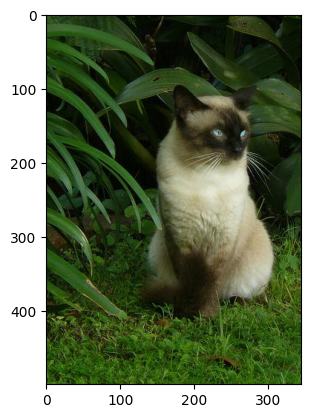

In [ ]:
from torchvision import transforms
example_dict = dataset['train'][0]
print(example_dict["path"])
print(example_dict["label"])
print(example_dict["dog"])
plt.imshow(example_dict["image"])

In [ ]:
labels = dataset['train'].unique('label')
print(len(labels),labels)

37 ['Siamese', 'Birman', 'shiba inu', 'staffordshire bull terrier', 'basset hound', 'Bombay', 'japanese chin', 'chihuahua', 'german shorthaired', 'pomeranian', 'beagle', 'english cocker spaniel', 'american pit bull terrier', 'Ragdoll', 'Persian', 'Egyptian Mau', 'miniature pinscher', 'Sphynx', 'Maine Coon', 'keeshond', 'yorkshire terrier', 'havanese', 'leonberger', 'wheaten terrier', 'american bulldog', 'english setter', 'boxer', 'newfoundland', 'Bengal', 'samoyed', 'British Shorthair', 'great pyrenees', 'Abyssinian', 'pug', 'saint bernard', 'Russian Blue', 'scottish terrier']


Veamos algunas imágenes de muestra de nuestro dataset.

Para cualquier conjunto de datos que usemos con la biblioteca `datasets`, podemos mezclarlo usando `shuffle()` y seleccionar cualquier muestra usando el método `select()`.

In [ ]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_samples(dataset['train'],rows=3,cols=5)

Output hidden; open in https://colab.research.google.com to view.

### Preprocesamiento de nuestro conjunto de datos
---

Cuando se trata de datasets de imágenes, el preprocesamiento implica varios pasos. Esto incluye transformaciones como cambiar el tamaño de todas las imágenes para que tengan las mismas dimensiones, normalizar y escalar los valores de píxeles a un rango uniforme. También podemos hacer augmentatio de imágenes aplicando giros aleatorios, rotaciones, perspectivas, etc.

Antes de aplicar nuestras transformaciones, dividamos nuestro conjunto de datos en 3 partes para entrenamiento, validación y un conjunto de pruebas oculto para evaluar el rendimiento de nuestro modelo. Podemos utilizar el método incorporado `train_test_split` para hacerlo.

Dado que solo tenemos una división de "entrenamiento" en nuestro dataset original, usaremos el 80% para entrenamiento y el 10% para "validación" y el 10% restante como nuestra división de "prueba".

In [ ]:
split_dataset = dataset['train'].train_test_split(test_size=0.2) # 80% train, 20% evaluation
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5) # 50% validation, 50% test

# recombining the splits using a DatasetDict

our_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

our_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    validation: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
})

Es importante tener en cuenta que ningún modelo puede comprender las etiquetas en su formato de string. Por lo tanto, los asignamos a sus contrapartes enteras. Como hay 37 etiquetas, las etiquetas se asignarán a un número del 0 al 36.

Crearemos dos asignaciones, `label2id` y `id2label` para convertir las etiquetas a sus ID y viceversa. Esto también será útil cuando inicialicemos nuestro modelo para actualizar su configuración.

In [ ]:
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

#### Image Processor

Para aplicar las transformaciones correctas en nuestras imágenes, usaremos [AutoImageProcessor](https://huggingface.co/docs/transformers/main_classes/image_processor) que aplicará las transformaciones de acuerdo con el modelo que usaremos. Podemos verificar su configuración para ver qué transformaciones se aplicarán.

In [ ]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Para aplicar las transformaciones a un lote en el momento del entrenamiento, podemos crear una función que preprocesará el lote. El `Trainer` llamará a esta función cuando la agreguemos al conjunto de datos usando `with_transform`.

En el momento del entrenamiento, debemos aplicar las transformaciones en un lote de muestras. Para manejar los lotes, crearemos una función "`transforms`" que se encargará de lo siguiente:

- Convertir todas las imágenes a RGB: es posible que algunas imágenes de su conjunto de datos sean en escala de grises o transparentes (RGBA).
- Convertir las etiquetas de las cadenas a números enteros: usando el mapa `label2id`.
- Aplicar transformaciones de imágenes: pasamos las imágenes por el `processor` para procesarlas y convertirlas al formato PyTorch.

Las características del conjunto de datos resultantes serán:
```py
{
     'pixel_values': torch.Tensor,
     'etiquetas': List
}
```

Emparejaremos la función con nuestro conjunto de datos usando el método `with_transform()`.

In [ ]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

In [ ]:
processed_dataset = our_dataset.with_transform(transforms)

#### Data Collation
Al proceso de agrupar nuestros datos en el formato correcto se lo denomina `Data Collation`. Para `pixel_values`, la forma de entrada para el modelo debe ser `(batch, channels, alto, ancho)` y para `labels`, la forma debe ser `(batch,)`

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Veamos cómo calcular las métricas.
---

Podemos utilizar la biblioteca `evaluate` de Hugging Face para calcular las métricas. Para la clasificación de imágenes, podemos utilizar la métrica de `accuracy`.

In [ ]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

### Cargando nuestro modelo
---

Usaremos [ViTForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTForImageClassification) para cargar nuestro modelo pre-entrenado.

Necesitamos actualizar la capa de clasificación final para generar predicciones iguales a la cantidad de etiquetas en nuestro conjunto de datos.
Lo haremos pasando el argumento `num_labels` junto con nuestras asignaciones de etiquetas `id2label` y `label2id`.

También necesitamos pasar `ignore_mismatched_sizes = True` para compensar el cambio en el número de parámetros en la capa de clasificación.

In [ ]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Aquí está la arquitectura de nuestro modelo.

In [ ]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

Como no vamos a actualizar todo el modelo, podemos "congelar" todos los parámetros excepto la nueva capa `classifier` estableciendo `requires_grad` en False para los parámetros de cada capa.

In [ ]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

Podemos comprobar cuántos parámetros hay en el modelo junto con cuántos se van a entrenar ahora.


In [ ]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,827,109 | trainable_params = 28,453


### Comencemos nuestro entrenamiento 🚀️🚀️🚀️
---

Vamos a usar [Hugging Face Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer) para entrenar nuestro modelo. De esta manera, es más simple elegir los argumentos de entrenamiento, como el tamaño del lote, la tasa de aprendizaje, la cantidad de épocas, las opciones de logging, etc.

Con respecto a la clasificación de imágenes, necesitamos configurar `remove_unused_columns=False` para evitar que se elimine la columna `image` de nuestro conjunto de datos, ya que es la que se utiliza para crear nuestras entradas de `pixel_values`.

In [ ]:
pip install accelerate -U

In [ ]:
training_args = TrainingArguments(
    output_dir="./vit-base-oxford-iiit-pets",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.391700,0.305208,0.936401
2,0.218300,0.228821,0.944520
3,0.175900,0.210024,0.940460
4,0.141200,0.202139,0.944520
5,0.138300,0.200130,0.941813


TrainOutput(global_step=1850, training_loss=0.30344832446124104, metrics={'train_runtime': 582.0088, 'train_samples_per_second': 50.79, 'train_steps_per_second': 3.179, 'total_flos': 2.2913817801515827e+18, 'train_loss': 0.30344832446124104, 'epoch': 5.0})

Evaluamos en nuestro conjunto de datos de prueba

In [ ]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.20417460799217224,
 'eval_accuracy': 0.9404600811907984,
 'eval_runtime': 16.4515,
 'eval_samples_per_second': 44.92,
 'eval_steps_per_second': 5.653,
 'epoch': 5.0}

¡Veamos algunas de las predicciones hechas por nuestro nuevo modelo!

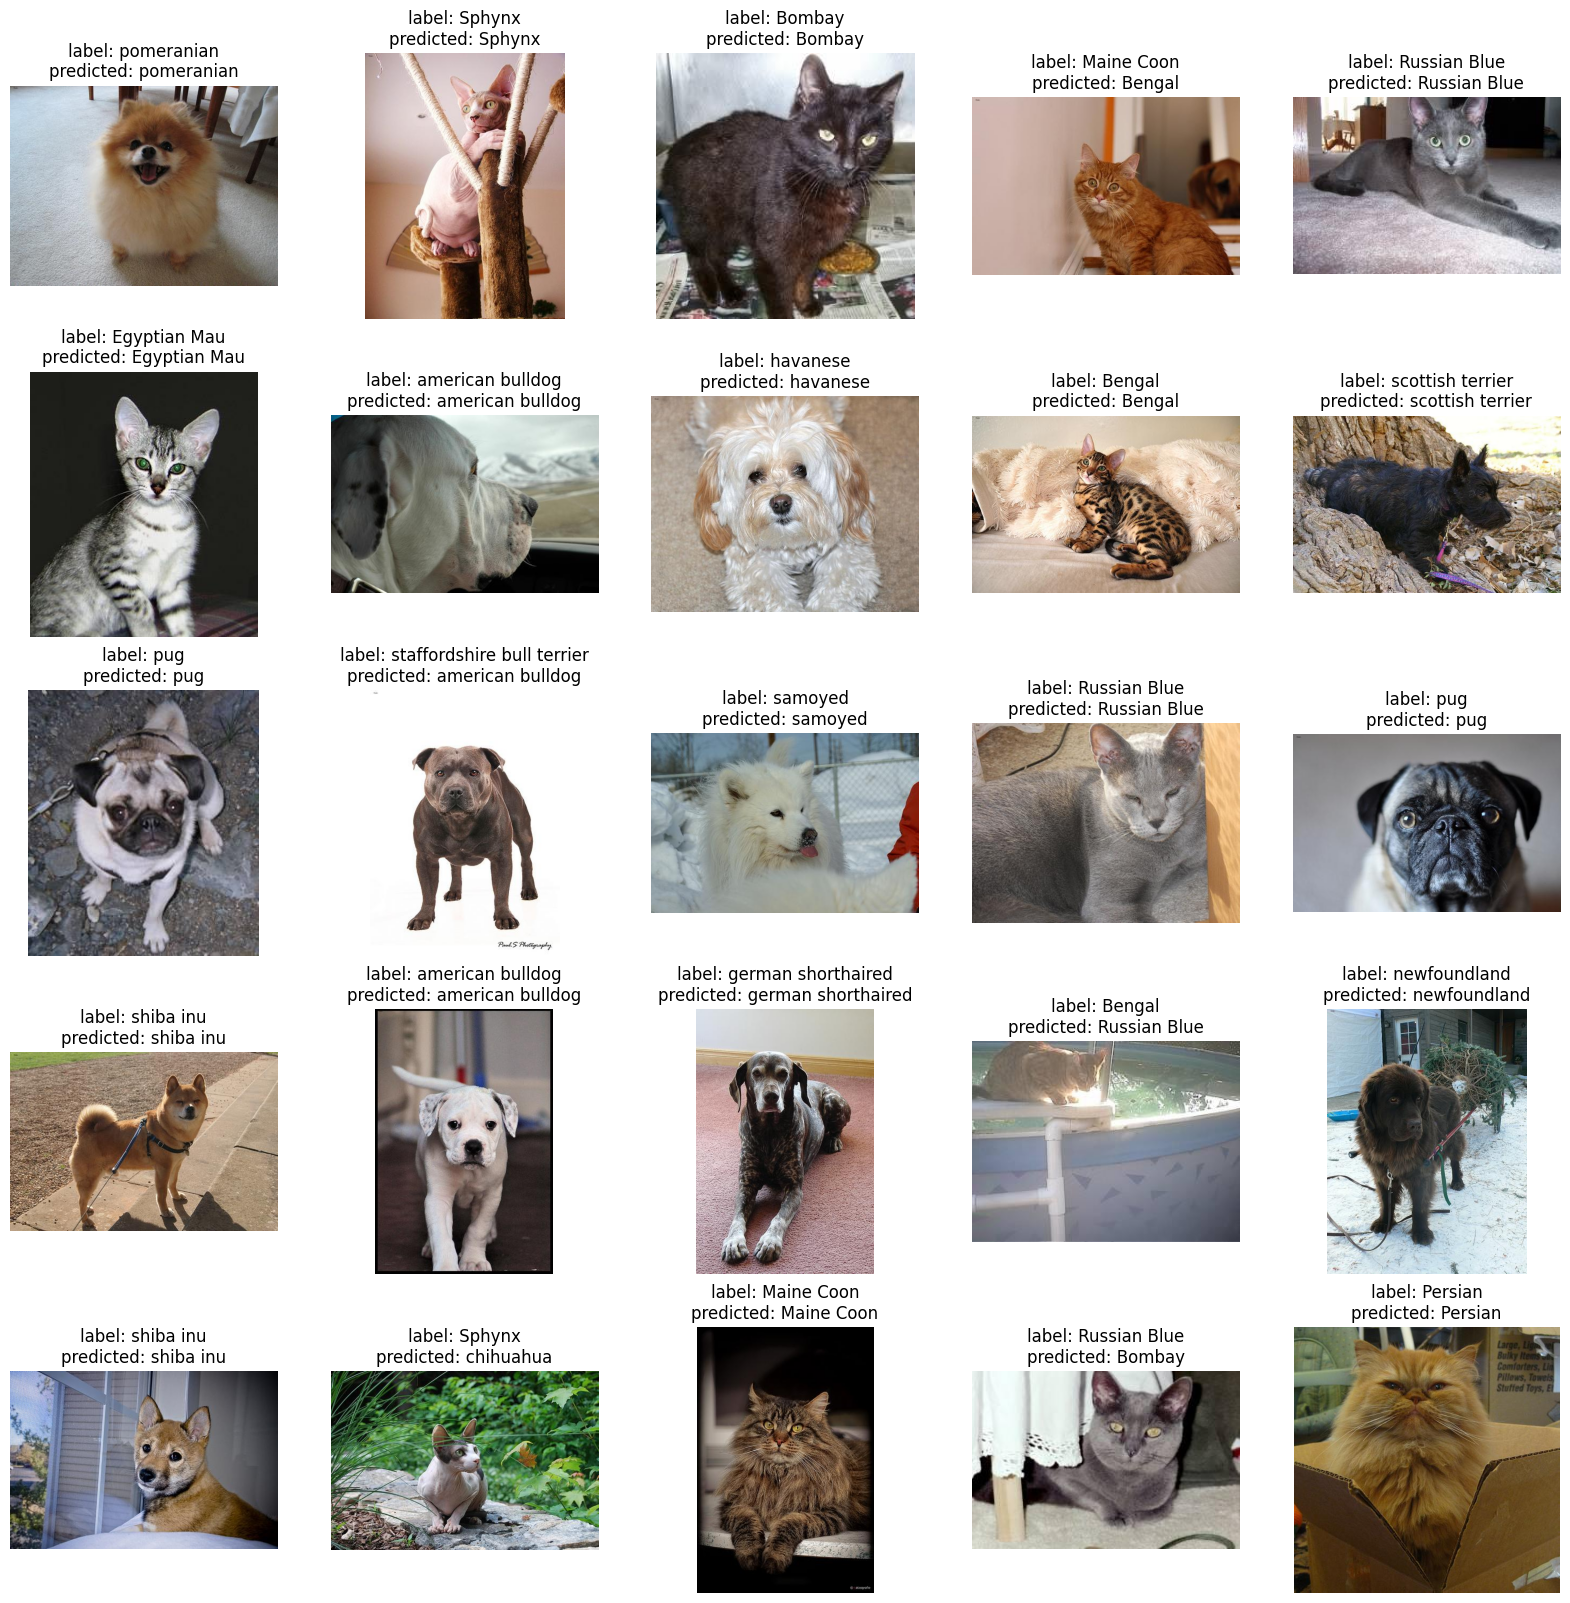

In [ ]:
def show_predictions(rows,cols):
    samples = our_dataset['test'].shuffle().select(np.arange(rows*cols))
    processed_samples = samples.with_transform(transforms)
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # predicted labels from logits
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(rows*cols):
        img = samples[i]['image']
        prediction = predictions[i]
        label = f"label: {samples[i]['label']}\npredicted: {id2label[prediction]}"
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_predictions(rows=5,cols=5)